# OASIS AS_REQ DAM
OASIS AS_REQ Day Ahead Market Report(s)

## Download Data

#### To run this report, first downloaded the database into the same directory as this notebook, and unzip it.
See this page for the list of available reports and the download links:

https://github.com/energy-analytics-project/energy-dashboard/blob/master/docs/datasets.md

## Preview Data

#### Then check to see what tables are available using the command line and sqlite3

```bash
$ sqlite3 data-oasis-as-req-dam_00.db ".tables"
```

```
disclaimer_item  messagepayload   report_data      report_item    
messageheader    oasisreport      report_header    rto  
```

#### Look at table structure

```bash
$ sqlite3 data-oasis-as-req-dam_00.db ".tables" | sed 's/ /\n/g' | sed '/^\s*$/d'
```

```bash
disclaimer_item
messagepayload
report_data
report_item
messageheader
oasisreport
report_header
rto
```


```bash
sqlite3 data-oasis-as-req-dam_00.db ".tables" | sed 's/ /\n/g' | sed '/^\s*$/d' | xargs -L 1 -I {} sqlite3 data-oasis-as-req-dam_00.db "pragma table_info([{}]);"
```

```bash
0|disclaimer|TEXT|0||1
1|rto_name|TEXT|0||0

0|id|TEXT|0||1
1|oasisreport_id|TEXT|0||0

0|interval_num|INTEGER|0||1
1|interval_start_gmt|TEXT|0||2
2|resource_name|TEXT|0||3
3|interval_end_gmt|TEXT|0||4
4|opr_date|TEXT|0||5
5|value|INTEGER|0||6
6|data_item|TEXT|0||7
7|report_item_id|TEXT|0||0

0|id|TEXT|0||1
1|rto_name|TEXT|0||0
0|timedate|TEXT|0||1
1|source|TEXT|0||2
2|version|TEXT|0||3
3|oasisreport_id|TEXT|0||0

0|id|TEXT|0||1

0|report|TEXT|0||1
1|system|TEXT|0||2
2|uom|TEXT|0||3
3|mkt_type|TEXT|0||5
4|sec_per_interval|INTEGER|0||4
5|interval|TEXT|0||6
6|tz|TEXT|0||7
7|report_item_id|TEXT|0||0

0|name|TEXT|0||1
1|messagepayload_id|TEXT|0||0
```

So it's clear that report_data, report_header, and report_item are the important tables here.

## Load Data

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf

# Create the connection to the unzipped database
cnx  = sqlite3.connect(r'./data-oasis-as-req-dam_00.db')

## Preview the schema

In [5]:
for table in ['disclaimer_item','messagepayload','report_data','report_item','messageheader','oasisreport','report_header','rto']:      
    print("--------------------------------------------------")
    print("table: %s" % table)
    print("--------------------------------------------------")
    for row in cnx.execute("PRAGMA table_info([%s]);" % table):
         print(row)

--------------------------------------------------
table: disclaimer_item
--------------------------------------------------
(0, 'id', 'TEXT', 0, None, 1)
(1, 'disclaimer', 'TEXT', 0, None, 0)
(2, 'rto_id', 'TEXT', 0, None, 0)
--------------------------------------------------
table: messagepayload
--------------------------------------------------
(0, 'id', 'TEXT', 0, None, 1)
(1, 'oasisreport_id', 'TEXT', 0, None, 0)
--------------------------------------------------
table: report_data
--------------------------------------------------
(0, 'id', 'TEXT', 0, None, 1)
(1, 'interval_end_gmt', 'TEXT', 0, None, 0)
(2, 'interval_start_gmt', 'TEXT', 0, None, 0)
(3, 'opr_date', 'TEXT', 0, None, 0)
(4, 'value', 'REAL', 0, None, 0)
(5, 'resource_name', 'TEXT', 0, None, 0)
(6, 'interval_num', 'INTEGER', 0, None, 0)
(7, 'data_item', 'TEXT', 0, None, 0)
(8, 'report_item_id', 'TEXT', 0, None, 0)
--------------------------------------------------
table: report_item
----------------------------------

## Select Data

In [3]:
df = pd.read_sql("select report_data.data_item, report_data.value, report_header.uom, report_header.report, report_header.mkt_type, report_data.interval_start_gmt, report_data.interval_end_gmt from report_header inner join report_data on report_header.report_item_id = report_data.report_item_id;", cnx)
df[0:5]

,data_item,value,uom,report,mkt_type,interval_start_gmt,interval_end_gmt
0,NS_REQ_MAX_MW,0.00,MW,AS_REQ,DAM,2016-03-08T07:00:00-00:00,2016-03-08T08:00:00-00:00
1,NS_REQ_MIN_MW,407.59,MW,AS_REQ,DAM,2016-03-08T07:00:00-00:00,2016-03-08T08:00:00-00:00
2,RD_REQ_MAX_MW,500.00,MW,AS_REQ,DAM,2016-03-08T07:00:00-00:00,2016-03-08T08:00:00-00:00
3,RD_REQ_MIN_MW,10.00,MW,AS_REQ,DAM,2016-03-08T07:00:00-00:00,2016-03-08T08:00:00-00:00
4,RU_REQ_MAX_MW,0.00,MW,AS_REQ,DAM,2016-03-08T07:00:00-00:00,2016-03-08T08:00:00-00:00


## Reports

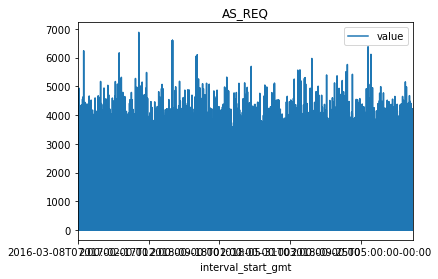

In [4]:
for title, group in df.groupby(['report']):
    group.plot.line(x='interval_start_gmt', y='value', title=title)